# Basic power spectrum estimation with lss-ps


The galaxy-clustering power spectrum is computed in 4 steps.

1: Load galaxy (data) and random catalgoues

The catalogue contains positions $(x_i, y_i, z_i)$, weights $w_i$ and mean density $\bar{n}_i$ . The mean density $\bar{n}(\vec{x}) = \langle n_{data}(\vec{x})\rangle$ is the ensemble average of the galaxy density; number density without clustering.

2: Compute number density fields,$n_{data}(\vec{x})$ and $n_{rand}(\vec{x})$, on grids from positions.

3 Compute the 'fluctuation field',

$$ F(\vec{x}) = n_{data}(\vec{x}) - \alpha n_{rand}(\vec{x}),$$

and Fast Fourier Transform the fluctuation field, where $\alpha$ is the data to random ratio,

$$ \alpha = \sum_i w_{data,i} \big/ \sum_i w_{rand,i}$$.

The number of randoms is usually 10-50 times larger than that of the data to reduce shot noise.


4 Compute the multipoles of the power spectrum

$$\tilde{P}(\vec{k}) = \frac{1}{\mathcal{N}} F(k) F(k)^* - \mathcal{S}$$

where,
$$ \mathcal{N} = \sum_{i} \bar{n}_{rand, i} w_{rand, i}^2 $$

$$ \mathcal{S} = \sum_{rand, i} w_{rand, i}^2 / \mathcal{N} $$



### Reference

Feldman, Kaiser, and Peacock (1994), *Power-spectrum analysis of three-dimensional redshift surveys*, *ApJ* **426**, 23-37


x0 =  (2074.0077, -294.5243, -294.5243)


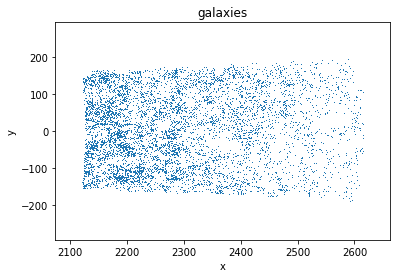

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math
import lssps

# load data (galaxy)) and random catalogues
with np.load('../data/mock_vipers.npz') as f:
    data = f['data'] # x y z nbar weight
    rand = f['rand'] # x y z nbar

# The estimator uses a box for Fast Fourier Transform (FFT)
boxsize = 589.0486 # length of the cubic box on a side
center_x = 0.5*(np.min(rand[:, 0]) + np.max(rand[:, 0]))
x0 = (center_x - 0.5*boxsize, -0.5*boxsize, -0.5*boxsize) # corner of the box

print('x0 = ', x0)

# Plot galaxy catalogue
plt.figure()
plt.title('galaxies')
plt.xlim(x0[0], x0[0] + boxsize)
plt.ylim(x0[1], x0[1] + boxsize)
plt.xlabel('x')
plt.ylabel('y')
plt.plot(data[:, 0], data[:, 1], ',')
plt.show()

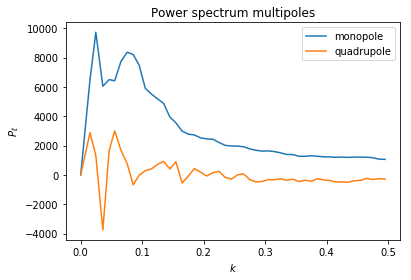

In [6]:
# Create grids for densities
nc = 96 # number of density grids per dimension
grid = lssps.grid.zeros(nc, boxsize, x0)
grid_rand = lssps.grid.zeros(nc, boxsize, x0)

# Compute the density fields
# One can choose mass assignment scheme from mas='NGP', CIC', and 'TSC'.
grid.assign_density(xyz=data[:, :3], nbar=data[:, 3], weight=data[:, 4], mas='CIC')
grid_rand.assign_density(xyz=rand[:, :3], nbar=rand[:, 3], mas='CIC')

# Subtract the randoms and obtain the fluctuation field
grid.compute_fluctuation(grid_rand)

ps = lssps.power_spectrum.compute_plane_parallel(grid, k_min=0.0, k_max=0.5, dk=0.01,
                                                 line_of_sight=0)

# Plot power spectrum
plt.figure()
plt.title('Power spectrum multipoles')
plt.xlabel('$k$')
plt.ylabel('$P_\ell$')
plt.plot(ps.k, ps.P0, label='monopole')
plt.plot(ps.k, ps.P2, label='quadrupole')
plt.legend()
plt.show()